# LOAD MODEL

In [33]:

import os
import sys
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.distributed as dist
from tqdm import tqdm
from einops import rearrange, reduce, repeat
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import ASTConfig, ASTModel, GPT2Config, GPT2Model, AutoModelForCausalLM, GPT2LMHeadModel, BartConfig
from einops_exts import rearrange_with_anon_dims
from einops import rearrange, reduce, repeat
from torch.nn import Transformer

prefix = '/workspace/pj/out/chord_bpe/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(device)

class GPT2Model(nn.Module):
    def __init__(self, vocab_size=140, n_embd=768, n_layer=12, n_head=12):
        super(GPT2Model, self).__init__()
        self.configuration = GPT2Config(vocab_size=vocab_size, n_embd=n_embd, n_layer=n_layer, n_head=n_head, bos_token_id=2, eos_token_id=1)
        self.model = GPT2LMHeadModel(self.configuration)
        
        # self.optimizer = Adam(self.model.parameters(), lr=3e-5)
        # self.scheduler = optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.97 ** epoch)
    
    def get_embed(self, idx):
        embedding_layer = self.model.transformer.wte
        token_embedding = embedding_layer(torch.tensor([idx]))
        return token_embedding
    def extract_vocab_embeddings(self):
    # Extract all the embeddings for the entire vocabulary
        embedding_layer = self.model.transformer.wte
        vocab_embeddings = embedding_layer.weight.detach().clone()
        return vocab_embeddings

    def forward(self, input_ids, labels=None):
        attention_mask = self.make_mask(input_ids)
        output = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, output_hidden_states=True, last_h)
        return output
    
    def make_mask(self, input_ids):
        attention_mask = (input_ids != 0).long()
        return attention_mask
    
    def infer(self, input_ids, length=2048):
        if len(input_ids.shape) == 1:
            input_ids = input_ids.unsqueeze(0)
        if len(input_ids.shape) > 2:
            raise Exception
        
        if length > 2048:
            print("Max Length is 2048. Change Length Auto to 2048")
            length = 2048
        
        with torch.no_grad():
            for step in range(length):
                output = self.forward(input_ids)
                output = torch.argmax(output.logits, dim=2)

                predict = output[:,-1].unsqueeze(1)
                output_ids = torch.cat((input_ids, predict), dim=-1)

                input_ids = output_ids
                
                # if torch.all(predict.eq(0)):
                #     break
                
                if output_ids.shape[1] > 2048:
                    break

        return output_ids    

vocab_size = 150
model = GPT2Model(vocab_size=vocab_size)
model.load_state_dict(torch.load(prefix + '/GPT2_BPE_V150/model_207_0.4520_0.3645.pt', map_location=device))
model.to(device)
model.eval()

cpu


GPT2Model(
  (model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(150, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0): GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (1): GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (a

In [38]:
class GPT2Model(nn.Module):
    def __init__(self, vocab_size=140, n_embd=768, n_layer=12, n_head=12):
        super(GPT2Model, self).__init__()
        self.configuration = GPT2Config(vocab_size=vocab_size, n_embd=n_embd, n_layer=n_layer, n_head=n_head, bos_token_id=2, eos_token_id=1)
        self.model = GPT2LMHeadModel(self.configuration)
        
    def get_embed(self, idx):
        embedding_layer = self.model.transformer.wte
        token_embedding = embedding_layer(torch.tensor([idx]))
        return token_embedding
    
    def extract_vocab_embeddings(self):
        # Extract all the embeddings for the entire vocabulary
        embedding_layer = self.model.transformer.wte
        vocab_embeddings = embedding_layer.weight.detach().clone()
        return vocab_embeddings

    def forward(self, input_ids, labels=None, return_hidden_states=False):
        attention_mask = self.make_mask(input_ids)
        # Forward pass through the transformer to get hidden states
        transformer_outputs = self.model.transformer(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        # Extract hidden states before the projection
        hidden_states = transformer_outputs.last_hidden_state
        
        if return_hidden_states:
            return hidden_states

        # Project the hidden states to vocabulary size
        logits = self.model.lm_head(hidden_states)

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.configuration.vocab_size), labels.view(-1))
            return loss, logits
        return logits

    def make_mask(self, input_ids):
        attention_mask = (input_ids != 0).long()
        return attention_mask
    
    def infer(self, input_ids, length=2048):
        if len(input_ids.shape) == 1:
            input_ids = input_ids.unsqueeze(0)
        if len(input_ids.shape) > 2:
            raise Exception
        
        if length > 2048:
            print("Max Length is 2048. Change Length Auto to 2048")
            length = 2048
        
        with torch.no_grad():
            for step in range(length):
                logits = self.forward(input_ids)
                output = torch.argmax(logits, dim=2)

                predict = output[:,-1].unsqueeze(1)
                output_ids = torch.cat((input_ids, predict), dim=-1)

                input_ids = output_ids
                
                if output_ids.shape[1] > 2048:
                    break

        return output_ids
    
vocab_size = 150
model = GPT2Model(vocab_size=vocab_size)
model.load_state_dict(torch.load(prefix + '/GPT2_BPE_V150/model_207_0.4520_0.3645.pt', map_location=device))
model.to(device)
model.eval()


GPT2Model(
  (model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(150, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0): GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (1): GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (a

In [41]:
test_chord = torch.tensor([[2,5,3,2,3,123,54,23,55,64,75,17,78,65,78,1]])

test_out = model(test_chord, return_hidden_states=False)

print(test_chord.shape)
print(test_out.shape)
# print(test_out.logits.shape)
# print(len(test_out.hidden_states))
# print(len(test_out.past_key_values))
# print(len(test_out.past_key_values[0]))
# print(len(test_out.past_key_values[0][0]))
# print(test_out.past_key_values[0][0].shape)

tensor([[[ -9.2142,  -9.6518,  -2.5480,  ..., -12.1701, -12.1874, -12.1918],
         [-16.9474, -11.8932,  -6.3359,  ..., -12.7175, -12.4567, -12.6532],
         [ -9.3622,  -5.2746,  -3.9125,  ..., -12.3754, -12.3590, -12.3221],
         ...,
         [ -0.7389,  -5.8941,  -0.7213,  ...,  -3.0598,  -3.2650,  -2.9826],
         [ -4.4293,   1.9191,  -0.9731,  ...,  -7.0239,  -7.2183,  -7.1300],
         [ 30.4422,  -4.6874,   0.4283,  ...,   2.6992,   2.8617,   2.7875]]],
       grad_fn=<UnsafeViewBackward0>)


AttributeError: 'Tensor' object has no attribute 'logits'

# Extract Vocab PT

In [21]:
import torch

vocab_embeddings = model.extract_vocab_embeddings()  # Assuming `model` is an instance of `GPT2Model`
torch.save(vocab_embeddings, '/workspace/pj/data/tensor/vocab_embeddings.pt')


# Check Vocab Embed

In [2]:
import torch
import torch.nn.functional as F

a = model.get_embed(4)

for i in range(150):
    ref = model.get_embed(i)
    sim = F.cosine_similarity(a, ref, dim=1)
    print(f'IDX {i} Sim : {sim}')

IDX 0 Sim : tensor([-0.1279], grad_fn=<SumBackward1>)
IDX 1 Sim : tensor([-0.0119], grad_fn=<SumBackward1>)
IDX 2 Sim : tensor([-0.1130], grad_fn=<SumBackward1>)
IDX 3 Sim : tensor([0.0788], grad_fn=<SumBackward1>)
IDX 4 Sim : tensor([1.], grad_fn=<SumBackward1>)
IDX 5 Sim : tensor([0.1321], grad_fn=<SumBackward1>)
IDX 6 Sim : tensor([0.1171], grad_fn=<SumBackward1>)
IDX 7 Sim : tensor([0.0475], grad_fn=<SumBackward1>)
IDX 8 Sim : tensor([0.0366], grad_fn=<SumBackward1>)
IDX 9 Sim : tensor([-0.1701], grad_fn=<SumBackward1>)
IDX 10 Sim : tensor([0.0989], grad_fn=<SumBackward1>)
IDX 11 Sim : tensor([0.0546], grad_fn=<SumBackward1>)
IDX 12 Sim : tensor([-0.1095], grad_fn=<SumBackward1>)
IDX 13 Sim : tensor([-0.1712], grad_fn=<SumBackward1>)
IDX 14 Sim : tensor([-0.1170], grad_fn=<SumBackward1>)
IDX 15 Sim : tensor([-0.0224], grad_fn=<SumBackward1>)
IDX 16 Sim : tensor([-0.0585], grad_fn=<SumBackward1>)
IDX 17 Sim : tensor([-0.0365], grad_fn=<SumBackward1>)
IDX 18 Sim : tensor([-0.0977], g

In [3]:
import torch
import torch.nn.functional as F

# Get the embedding of the token with index 4
a = model.get_embed(4)

max_sim = float('-inf')  # Initialize max similarity with a very small number
min_sim = float('inf')   # Initialize min similarity with a very large number
max_idx = -1             # Initialize index for max similarity
min_idx = -1             # Initialize index for min similarity

# Iterate over token indices from 0 to 149
for i in range(150):
    if i == 4:
        continue  # Skip comparison with itself
    
    ref = model.get_embed(i)          # Get the embedding for the current token index
    sim = F.cosine_similarity(a, ref, dim=1)  # Calculate cosine similarity
    
    # Update max similarity and corresponding index
    if sim > max_sim:
        max_sim = sim
        max_idx = i
    
    # Update min similarity and corresponding index
    if sim < min_sim:
        min_sim = sim
        min_idx = i

# Output the results
print(f'Max Similarity: IDX {max_idx} Sim: {max_sim.item()}')
print(f'Min Similarity: IDX {min_idx} Sim: {min_sim.item()}')


Max Similarity: IDX 5 Sim: 0.13207107782363892
Min Similarity: IDX 57 Sim: -0.25625184178352356


In [4]:
import torch
import torch.nn.functional as F

Major = [4,81,26,103,48,125,70,15,92,37,114,59]
minor = [105, 50, 127, 72, 17, 94, 39, 116, 61, 6, 83, 28]

Major = [(i*11 + 4) for i in range(12)]
minor = [(i*11 + 6) for i in range(12)]
chord = Major + minor
print(chord)
# Get the embedding of the token with index 4
a = model.get_embed(103)

max_sim = float('-inf')  # Initialize max similarity with a very small number
min_sim = float('inf')   # Initialize min similarity with a very large number
max_idx = -1             # Initialize index for max similarity
min_idx = -1             # Initialize index for min similarity

# Iterate over token indices from 0 to 149
for i in chord:
    if i == 103:
        continue  # Skip comparison with itself
    
    ref = model.get_embed(i)          # Get the embedding for the current token index
    sim = F.cosine_similarity(a, ref, dim=1)  # Calculate cosine similarity
    
    # Update max similarity and corresponding index
    if sim > max_sim:
        max_sim = sim
        max_idx = i
    
    # Update min similarity and corresponding index
    if sim < min_sim:
        min_sim = sim
        min_idx = i

# Output the results
print(f'Max Similarity: IDX {max_idx} Sim: {max_sim.item()}')
print(f'Min Similarity: IDX {min_idx} Sim: {min_sim.item()}')


[4, 15, 26, 37, 48, 59, 70, 81, 92, 103, 114, 125, 6, 17, 28, 39, 50, 61, 72, 83, 94, 105, 116, 127]
Max Similarity: IDX 105 Sim: 0.13172677159309387
Min Similarity: IDX 6 Sim: -0.09109531342983246


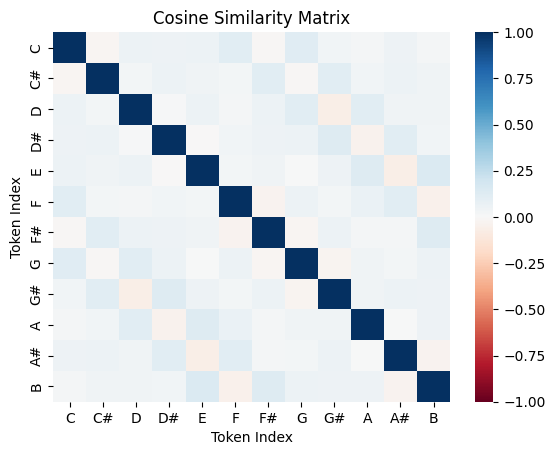

In [40]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Assume we have 150 tokens (0 to 149)
num_tokens = 12

# Initialize an empty matrix to store cosine similarities
cos_sim_matrix = torch.zeros((num_tokens, num_tokens))

custom_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

# Iterate over all pairs of token indices
for i, ci in enumerate(Major):
    embedding_i = model.get_embed(ci)
    
    for j, cj in enumerate(Major):  # Only iterate over the upper triangle and diagonal
        embedding_j = model.get_embed(cj)
        sim = F.cosine_similarity(embedding_i, embedding_j, dim=1)
        cos_sim_matrix[i, j] = sim
        cos_sim_matrix[j, i] = sim  # Symmetric matrix

# Convert the cosine similarity matrix to a NumPy array for plotting
cos_sim_matrix_np = cos_sim_matrix.detach().numpy()

# Create a heatmap using seaborn
sns.heatmap(cos_sim_matrix_np, annot=False, cmap="RdBu", cbar=True, vmin=-1, vmax=1,
            xticklabels=custom_labels, yticklabels=custom_labels)

# Add labels and a title
plt.title("Cosine Similarity Matrix")
plt.xlabel("Token Index")
plt.ylabel("Token Index")

# Display the plot
plt.show()


[6, 17, 28, 39, 50, 61, 72, 83, 94, 105, 116, 127]
0.10279877
-0.065785974


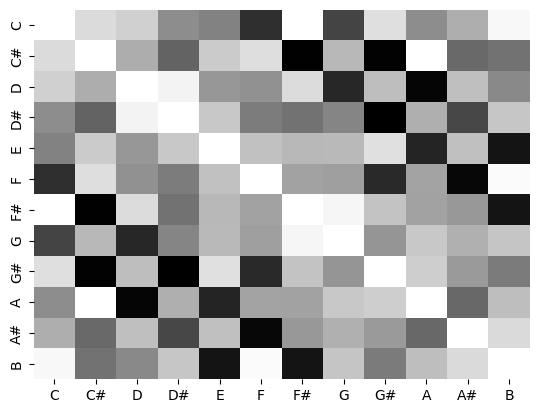

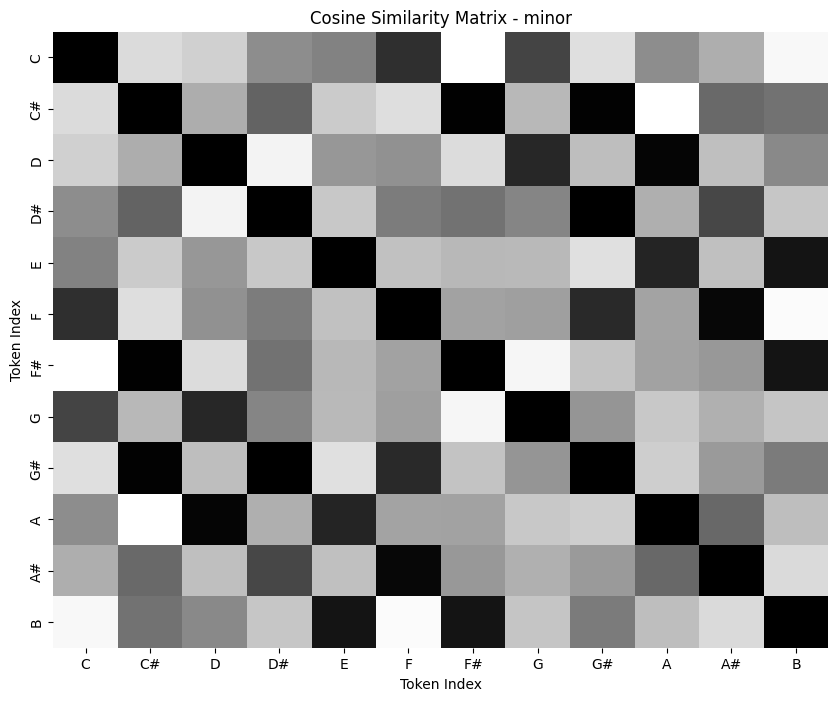

In [88]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume we have 150 tokens (0 to 149)
num_tokens = 12

# Initialize an empty matrix to store cosine similarities
cos_sim_matrix = torch.zeros((num_tokens, num_tokens))

custom_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
print(minor)
# Iterate over all pairs of token indices
for i, ci in enumerate(minor):
    embedding_i = model.get_embed(ci)
    
    for j, cj in enumerate(minor):  # Only iterate over the upper triangle and diagonal
        embedding_j = model.get_embed(cj)
        sim = F.cosine_similarity(embedding_i, embedding_j, dim=1)
        cos_sim_matrix[i, j] = sim
        cos_sim_matrix[j, i] = sim  # Symmetric matrix

# Convert the cosine similarity matrix to a NumPy array for plotting



cos_sim_matrix_np = cos_sim_matrix.detach().numpy()

np.fill_diagonal(cos_sim_matrix_np, np.nan)

current_min = np.nanmin(cos_sim_matrix_np)
current_max = np.nanmax(cos_sim_matrix_np)
print(current_max)
print(current_min)
# Create a heatmap using seaborn
sns.heatmap(cos_sim_matrix_np, annot=False, cmap="Greys", cbar=False,  # Disable colorbar
            vmin=current_min, vmax=current_max,
            xticklabels=custom_labels, yticklabels=custom_labels,
            mask=np.isnan(cos_sim_matrix_np))  # Mask the NaN values



plt.figure(figsize=(10, 8))

# Create a custom color map that uses black for NaN (which will be our diagonal)
cmap = sns.color_palette("Greys", as_cmap=True)
cmap.set_bad(color='black')

# Create a heatmap using seaborn
sns.heatmap(cos_sim_matrix_np, annot=False, cmap=cmap, cbar=False,
            vmin=current_min, vmax=current_max,
            xticklabels=custom_labels, yticklabels=custom_labels,
            mask=np.isnan(cos_sim_matrix_np))  # Mask the NaN values

# Add labels and a title
plt.title("Cosine Similarity Matrix - minor")
plt.xlabel("Token Index")
plt.ylabel("Token Index")

# Display the plot
plt.show()


[4, 15, 26, 37, 48, 59, 70, 81, 92, 103, 114, 125]


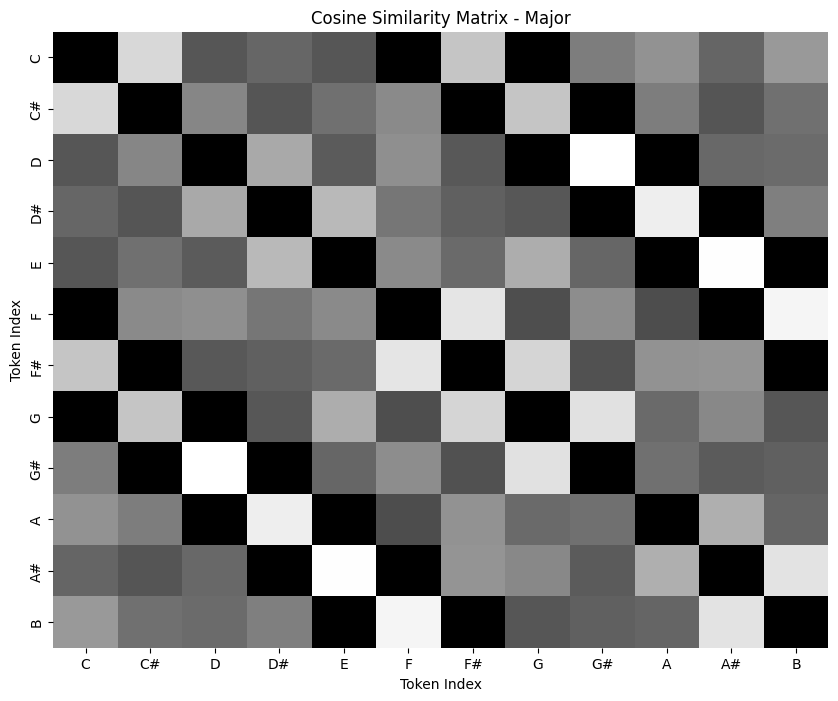

In [89]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume we have 150 tokens (0 to 149)
num_tokens = 12

# Initialize an empty matrix to store cosine similarities
cos_sim_matrix = torch.zeros((num_tokens, num_tokens))

custom_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
print(Major)
# Iterate over all pairs of token indices
for i, ci in enumerate(Major):
    embedding_i = model.get_embed(ci)
    
    for j, cj in enumerate(Major):  # Only iterate over the upper triangle and diagonal
        embedding_j = model.get_embed(cj)
        sim = F.cosine_similarity(embedding_i, embedding_j, dim=1)
        cos_sim_matrix[i, j] = sim
        cos_sim_matrix[j, i] = sim  # Symmetric matrix

# Convert the cosine similarity matrix to a NumPy array for plotting



cos_sim_matrix_np = cos_sim_matrix.detach().numpy()

np.fill_diagonal(cos_sim_matrix_np, np.nan)

plt.figure(figsize=(10, 8))

# Create a custom color map that uses black for NaN (which will be our diagonal)
cmap = sns.color_palette("Greys", as_cmap=True)
cmap.set_bad(color='black')

# Create a heatmap using seaborn
sns.heatmap(cos_sim_matrix_np, annot=False, cmap=cmap, cbar=False,
            vmin=current_min, vmax=current_max,
            xticklabels=custom_labels, yticklabels=custom_labels,
            mask=np.isnan(cos_sim_matrix_np))  # Mask the NaN values


# Add labels and a title
plt.title("Cosine Similarity Matrix - Major")
plt.xlabel("Token Index")
plt.ylabel("Token Index")

# Display the plot
plt.show()


[4, 15, 26, 37, 48, 59, 70, 81, 92, 103, 114, 125]


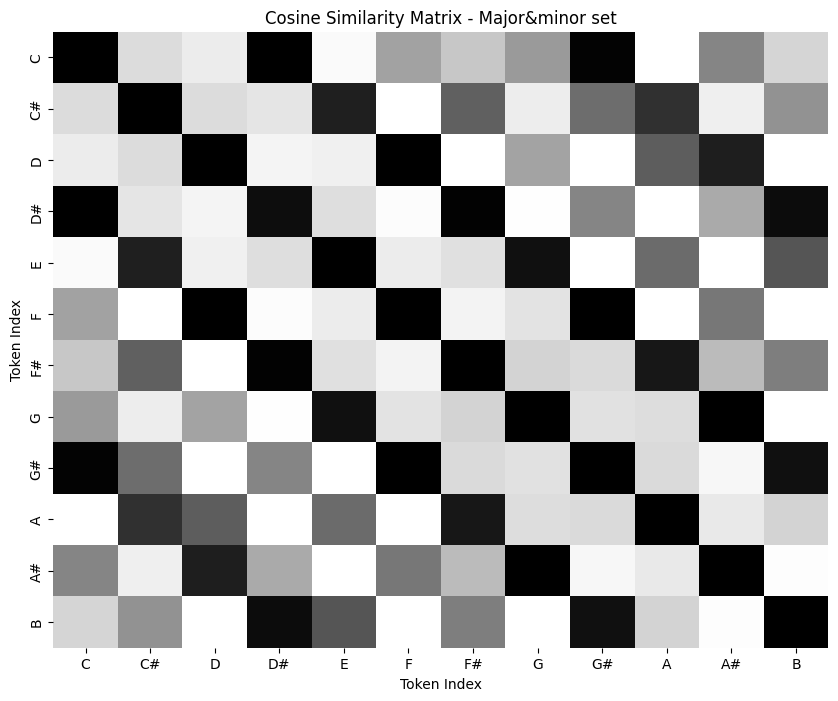

In [90]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume we have 150 tokens (0 to 149)
num_tokens = 12

# Initialize an empty matrix to store cosine similarities
cos_sim_matrix = torch.zeros((num_tokens, num_tokens))

custom_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
print(Major)
# Iterate over all pairs of token indices
for i, ci in enumerate(Major):
    embedding_i = model.get_embed(ci)
    
    for j, cj in enumerate(minor):  # Only iterate over the upper triangle and diagonal
        embedding_j = model.get_embed(cj)
        sim = F.cosine_similarity(embedding_i, embedding_j, dim=1)
        cos_sim_matrix[i, j] = sim
        cos_sim_matrix[j, i] = sim  # Symmetric matrix

# Convert the cosine similarity matrix to a NumPy array for plotting



cos_sim_matrix_np = cos_sim_matrix.detach().numpy()

# np.fill_diagonal(cos_sim_matrix_np, np.nan)

plt.figure(figsize=(10, 8))

# Create a custom color map that uses black for NaN (which will be our diagonal)
cmap = sns.color_palette("Greys", as_cmap=True)
cmap.set_bad(color='black')

# Create a heatmap using seaborn
sns.heatmap(cos_sim_matrix_np, annot=False, cmap=cmap, cbar=False,
            vmin=current_min, vmax=current_max,
            xticklabels=custom_labels, yticklabels=custom_labels,
            mask=np.isnan(cos_sim_matrix_np))  # Mask the NaN values


# Add labels and a title
plt.title("Cosine Similarity Matrix - Major&minor set")
plt.xlabel("Token Index")
plt.ylabel("Token Index")

# Display the plot
plt.show()


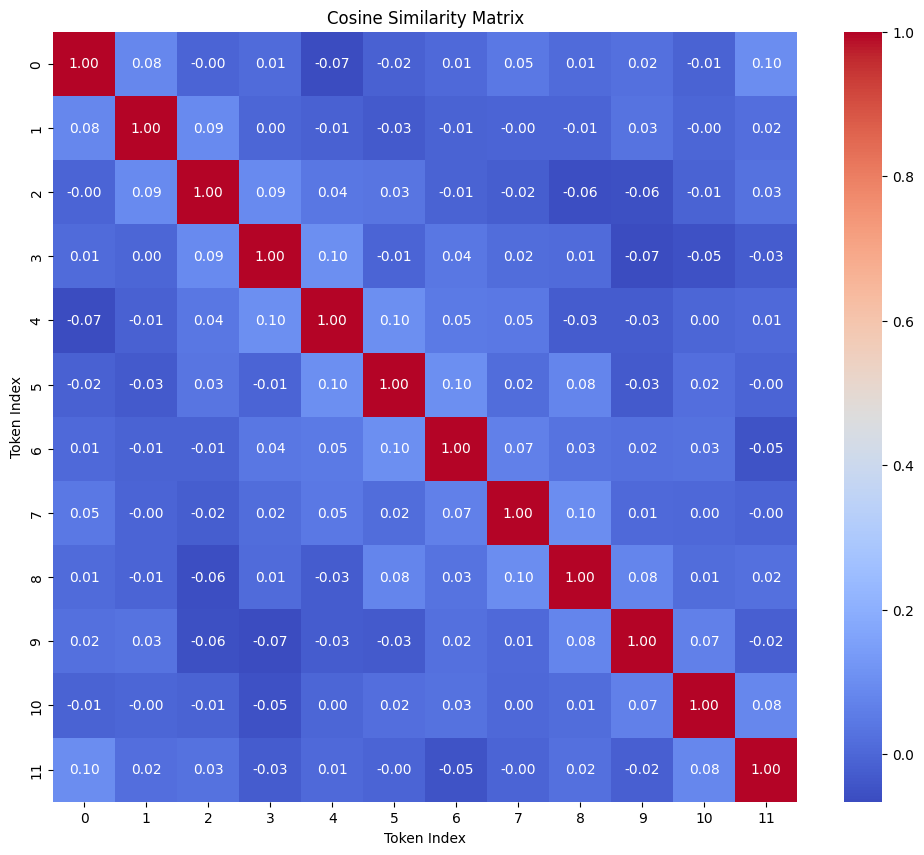

In [33]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Assume we have 150 tokens (0 to 149)
num_tokens = 12

# Initialize an empty matrix to store cosine similarities
cos_sim_matrix = torch.zeros((num_tokens, num_tokens))

# Iterate over all pairs of token indices
for i, ci in enumerate(minor):
    embedding_i = model.get_embed(ci)
    
    for j, cj in enumerate(minor):  # Only iterate over the upper triangle and diagonal
        embedding_j = model.get_embed(cj)
        sim = F.cosine_similarity(embedding_i, embedding_j, dim=1)
        cos_sim_matrix[i, j] = sim
        cos_sim_matrix[j, i] = sim  # Symmetric matrix

# Convert the cosine similarity matrix to a NumPy array for plotting
cos_sim_matrix_np = cos_sim_matrix.detach().numpy()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cos_sim_matrix_np, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Add labels and a title
plt.title("Cosine Similarity Matrix")
plt.xlabel("Token Index")
plt.ylabel("Token Index")

# Display the plot
plt.show()


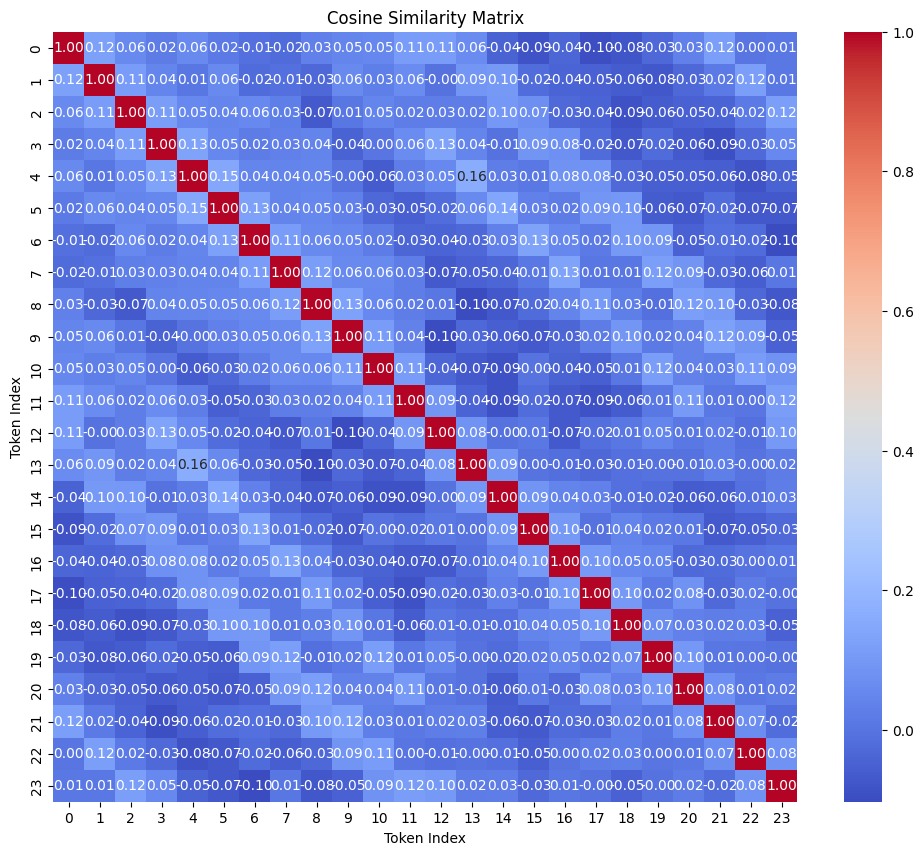

In [35]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Assume we have 150 tokens (0 to 149)
num_tokens = 24

# Initialize an empty matrix to store cosine similarities
cos_sim_matrix = torch.zeros((num_tokens, num_tokens))

# Iterate over all pairs of token indices
for i, ci in enumerate(chord):
    embedding_i = model.get_embed(ci)
    
    for j, cj in enumerate(chord):  # Only iterate over the upper triangle and diagonal
        embedding_j = model.get_embed(cj)
        sim = F.cosine_similarity(embedding_i, embedding_j, dim=1)
        cos_sim_matrix[i, j] = sim
        cos_sim_matrix[j, i] = sim  # Symmetric matrix

# Convert the cosine similarity matrix to a NumPy array for plotting
cos_sim_matrix_np = cos_sim_matrix.detach().numpy()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cos_sim_matrix_np, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Add labels and a title
plt.title("Cosine Similarity Matrix")
plt.xlabel("Token Index")
plt.ylabel("Token Index")

# Display the plot
plt.show()


[4, 15, 26, 37, 48, 59, 70, 81, 92, 103, 114, 125]
[134, 135, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133]


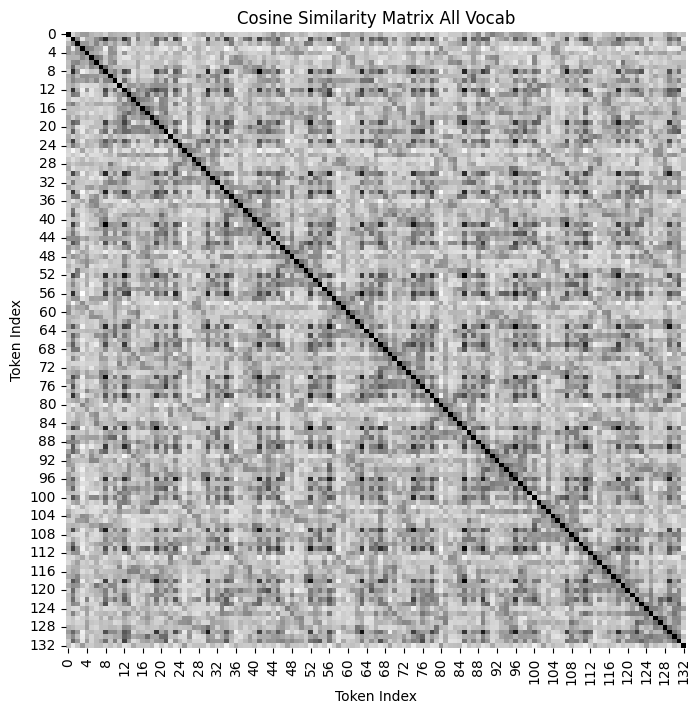

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume we have 150 tokens (0 to 149)
num_tokens = 133

# Initialize an empty matrix to store cosine similarities
cos_sim_matrix = torch.zeros((num_tokens, num_tokens))

custom_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
print(Major)

chord_seq = [134, 135]
c_s = [i for i in range(3,134)]
chord_seq = (chord_seq + c_s)

print(chord_seq)

# Iterate over all pairs of token indices
for i, ci in enumerate(chord_seq):
    embedding_i = model.get_embed(ci)
    
    for j, cj in enumerate(chord_seq):  # Only iterate over the upper triangle and diagonal
        embedding_j = model.get_embed(cj)
        sim = F.cosine_similarity(embedding_i, embedding_j, dim=1)
        cos_sim_matrix[i, j] = sim
        cos_sim_matrix[j, i] = sim  # Symmetric matrix

# Convert the cosine similarity matrix to a NumPy array for plotting



cos_sim_matrix_np = cos_sim_matrix.detach().numpy()

np.fill_diagonal(cos_sim_matrix_np, np.nan)

current_min = np.nanmin(cos_sim_matrix_np)
current_max = np.nanmax(cos_sim_matrix_np)

plt.figure(figsize=(8, 8))

# Create a custom color map that uses black for NaN (which will be our diagonal)
cmap = sns.color_palette("Greys", as_cmap=True)
cmap.set_bad(color='black')

# Create a heatmap using seaborn
sns.heatmap(cos_sim_matrix_np, annot=False, cmap=cmap, cbar=False,
            vmin=current_min, vmax=current_max,
            mask=np.isnan(cos_sim_matrix_np))  # Mask the NaN values

# Add labels and a title
plt.title("Cosine Similarity Matrix All Vocab")
plt.xlabel("Token Index")
plt.ylabel("Token Index")

# Display the plot
plt.show()


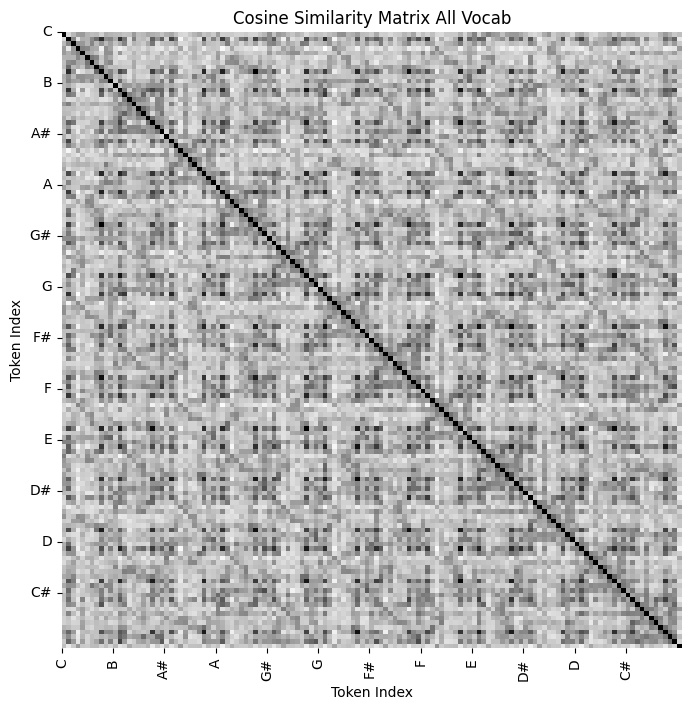

In [17]:
# Assuming 'custom_labels' are the 12 labels for the tokens
custom_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

# Generate tick positions at an interval of 11
tick_positions = list(range(0, num_tokens, 11))

# Create a list of labels at an interval of 11
custom_ticks = [custom_labels[i % len(custom_labels)] for i in range(0, num_tokens, 11)]

# If the first and last labels are the same, remove the last one
if custom_ticks[0] == custom_ticks[-1]:
    custom_ticks = custom_ticks[:-1]
    tick_positions = tick_positions[:-1]

plt.figure(figsize=(8, 8))

# Create a heatmap using seaborn
sns.heatmap(cos_sim_matrix_np, annot=False, cmap=cmap, cbar=False,
            vmin=current_min, vmax=current_max,
            mask=np.isnan(cos_sim_matrix_np))  # Mask the NaN values

# Set the custom ticks on both axes
plt.xticks(tick_positions, custom_ticks)
plt.yticks(tick_positions, custom_ticks)

# Add labels and a title
plt.title("Cosine Similarity Matrix All Vocab")
plt.xlabel("Token Index")
plt.ylabel("Token Index")

# Display the plot
plt.show()


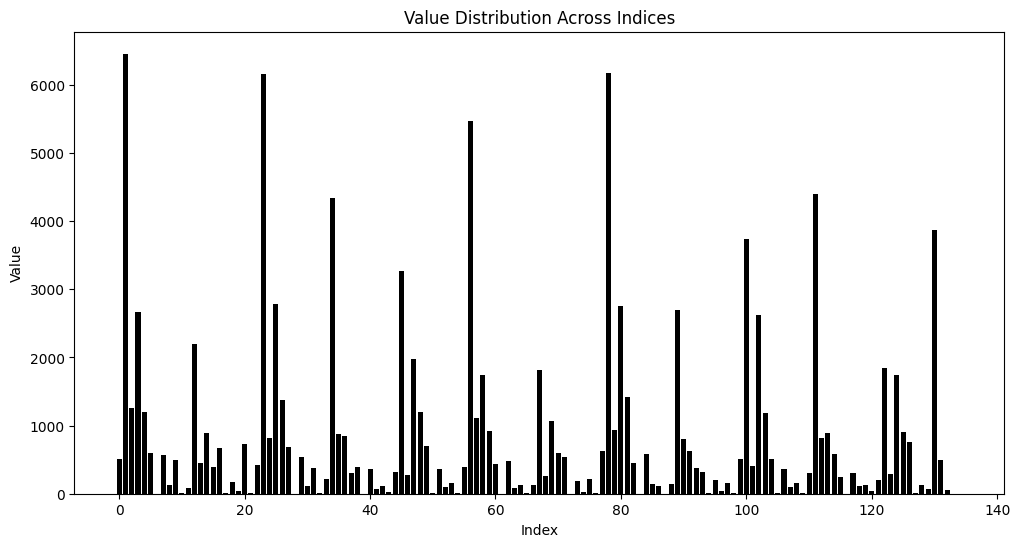

In [98]:
import matplotlib.pyplot as plt

# Your list of values
data = [0, 924, 924, 512, 6459, 1256, 2672, 1198, 605, 0, 573, 122, 489, 5, 83, 2203, 444, 897, 
        392, 672, 6, 178, 36, 724, 8, 416, 6156, 820, 2787, 1371, 691, 1, 535, 120, 374, 6, 217, 
        4343, 873, 843, 301, 390, 3, 361, 74, 120, 30, 317, 3274, 282, 1979, 1198, 696, 9, 364, 
        105, 164, 11, 385, 5473, 1113, 1739, 923, 429, 2, 476, 91, 122, 13, 132, 1817, 261, 1063, 
        600, 533, 3, 188, 27, 223, 11, 629, 6169, 942, 2751, 1415, 456, 3, 587, 147, 117, 2, 141, 
        2703, 797, 631, 375, 314, 11, 198, 42, 164, 11, 509, 3737, 410, 2628, 1180, 511, 7, 360, 
        105, 152, 9, 297, 4403, 825, 898, 576, 248, 3, 304, 111, 126, 37, 208, 1840, 284, 1738, 
        901, 762, 10, 134, 68, 3874, 501, 49, 0, 0]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(data[3:])), data[3:], color='black')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Test Set')
plt.show()
